In [ ]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt

from cmcrameri.cm import *
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd
import numpy as np
import os
from copy import deepcopy
import netCDF4 as nc

unit_Rjup = 69.911e3 # m
unit_Rear = 6.371e3  # m
unit_Mjup = 1.898e27 # kg
unit_Mear = 5.972e24 # kg

Gconst = 6.6743e-11

R_earth = 6.371e6
M_earth = 5.972e24
bar = 1e5 # Pa

# %matplotlib widget
# %config InlineBackend.figure_format = 'retina'

In [182]:
# data_dir = "/home/n/nichollsh/thesis_pipeline/data/"
data_dir = "/home2/p321409/Projects/thesis_pipeline/data/"

output_dir = os.path.abspath("../../out/")

plots_dir = os.path.join(output_dir,"plots")
if os.path.isdir(plots_dir):
    os.rmdir(plots_dir)
os.mkdir(plots_dir)

In [3]:
# Zeng MR curves (key = iron mass fraction)
zeng = {}

# Zeng pure silicate
zeng_sil = [ [0.0094, 0.2533], [0.0133, 0.2831], [0.0188, 0.3167], [0.0263, 0.3533], [0.0363, 0.3926], [0.0502, 0.436], [0.0668, 0.4778], [0.0883, 0.5214], [0.1151, 0.5659], [0.1453, 0.6064], [0.1882, 0.6542], [0.2467, 0.7083], [0.3252, 0.7682], [0.4289, 0.8332], [0.5643, 0.9031], [0.7393, 0.9772], [0.9634, 1.0552], [1.2479, 1.1368], [1.6061, 1.2214], [2.0541, 1.3089], [2.6105, 1.3987], [3.2973, 1.4906], [4.1404, 1.5844], [5.1702, 1.6797], [6.4220, 1.7763], [7.9376, 1.8739], [9.7656, 1.9725], [11.9628, 2.0718], [14.5957, 2.1716], [17.7419, 2.2719], [21.4589, 2.3716], [25.6899, 2.4665], [30.5051, 2.5564], [35.9972, 2.6420], [42.2655, 2.7237], [49.4164, 2.8016], [57.5637, 2.8759], [66.8285, 2.9467], [77.339, 3.0138], [89.2314, 3.0774], [102.6513, 3.1372], [117.7562, 3.1933], [134.7189, 3.2455], [153.7329, 3.2941], [175.0178, 3.3389], [198.8262, 3.3801], [225.4501, 3.4179], [255.2280, 3.4524], [288.5492, 3.484], [325.8570, 3.5128], [367.6497, 3.539], [414.4773, 3.5629], [466.9373, 3.5847], [525.6648, 3.6044], [591.3243, 3.6222], [664.5985, 3.6379] ]
zeng[0.0] = np.array(zeng_sil).T

# Zeng Earth like (32.5% Fe + silicate)
zeng_mix = [ [0.003, 0.1648], [0.0042, 0.1831], [0.0059, 0.2036], [0.0082, 0.2267], [0.0114, 0.2524], [0.0159, 0.281], [0.0221, 0.3128], [0.0306, 0.3476], [0.042, 0.3854], [0.0575, 0.4265], [0.0779, 0.4697], [0.1046, 0.515], [0.1393, 0.5625], [0.1831, 0.61], [0.2402, 0.6608], [0.3142, 0.7150], [0.4093, 0.7725], [0.5304, 0.8330], [0.6835, 0.8964], [0.8756, 0.9625], [1.115, 1.0309], [1.4114, 1.1015], [1.7763, 1.1741], [2.2233, 1.2485], [2.7682, 1.3245], [3.4297, 1.4019], [4.2296, 1.4806], [5.1932, 1.5604], [6.3505, 1.6412], [7.7363, 1.7228], [9.3912, 1.8052], [11.3628, 1.8883], [13.7066, 1.9719], [16.4870, 2.0559], [19.7797, 2.1404], [23.6585, 2.2246], [28.152, 2.3063], [33.3138, 2.3848], [39.2487, 2.4602], [46.0693, 2.5325], [53.8965, 2.6019], [62.8692, 2.6683], [73.1339, 2.7319], [84.8337, 2.7924], [98.1197, 2.8497], [113.1545, 2.9034], [130.1162, 2.9536], [149.2054, 3.0002], [170.6534, 3.0431]]
zeng[0.325] = np.array(zeng_mix).T

# Zeng pure iron
zeng_irn = [  [0.0021, 0.1175], [0.0029, 0.1314], [0.0041, 0.1469], [0.0057, 0.1641], [0.008, 0.1832], [0.0111, 0.2041], [0.0154, 0.2272], [0.0213, 0.2525], [0.0293, 0.2801], [0.0401, 0.31], [0.0546, 0.3422], [0.0739, 0.3768], [0.0993, 0.4138], [0.1326, 0.4529], [0.1758, 0.4943], [0.2313, 0.5376], [0.3023, 0.5828], [0.3921, 0.6297], [0.5051, 0.6781], [0.6462, 0.7279], [0.8212, 0.7789], [1.0371, 0.831], [1.3018, 0.884], [1.625, 0.9377], [2.0176, 0.9922], [2.4927, 1.0471], [3.0655, 1.1025], [3.7538, 1.1582], [4.5782, 1.2142], [5.5631, 1.2705], [6.7367, 1.3269], [8.1322, 1.3834], [9.7879, 1.4400], [11.7489, 1.4966], [14.0676, 1.5532], [16.805, 1.6099], [20.0062, 1.6660], [23.7165, 1.7209], [28.0181, 1.7747], [33.0006, 1.8275], [38.7619, 1.8791], [45.4074, 1.9294], [53.0498, 1.9785], [61.8097, 2.0260], [71.8161, 2.0719], [83.2082, 2.116], [96.1382, 2.1581], [110.7759, 2.1982], [127.3145, 2.2361] ]
zeng[1.0] = np.array(zeng_irn).T

In [ ]:
# Exoplanets
exo_file = os.path.join(data_dir,"exoplanet_eu.csv")
print(exo_file)
exo_raw = pd.read_csv(exo_file,delimiter=',')
exo_dat = exo_raw.loc[exo_raw['planet_status'] == 'Confirmed']

# Show values
exo_dat

/home2/p321409/Projects/thesis_pipeline/data/exoplanet_eu.csv


,name,planet_status,mass,mass_error_min,mass_error_max,mass_sini,mass_sini_error_min,mass_sini_error_max,radius,radius_error_min,...,star_sp_type,star_age,star_age_error_min,star_age_error_max,star_teff,star_teff_error_min,star_teff_error_max,star_detected_disc,star_magnetic_field,star_alternate_names
0,109 Psc b,Confirmed,5.743,0.28900,1.01100,6.3830,0.07800,0.07800,1.152,NaN,...,G5 IV,6.90,0.60,0.60,5600.0,80.000,80.000,NaN,NaN,HD 10697
1,112 Psc b,Confirmed,NaN,0.00500,0.00400,0.0330,0.00500,0.00400,NaN,NaN,...,G0IV,NaN,NaN,NaN,5986.0,105.437,105.437,NaN,NaN,HD 12235
2,112 Psc c,Confirmed,9.866,1.78100,3.19000,NaN,NaN,NaN,NaN,NaN,...,G0IV,NaN,NaN,NaN,5986.0,105.437,105.437,NaN,NaN,HD 12235
3,11 Com Ab,Confirmed,NaN,1.53491,1.53491,16.1284,1.53491,1.53491,NaN,NaN,...,G8III,NaN,NaN,NaN,4742.0,100.000,100.000,NaN,NaN,HD 107383
4,11 UMi b,Confirmed,NaN,1.10000,1.10000,11.0873,1.10000,1.10000,NaN,NaN,...,K4III,1.56,0.54,0.54,4340.0,70.000,70.000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7602,ZTF J1406+1222 Ab,Confirmed,50.000,NaN,NaN,NaN,NaN,NaN,0.292,NaN,...,PSR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7603,ZTF J1622+47 b,Confirmed,61.000,19.00000,19.00000,NaN,NaN,NaN,0.980,0.02,...,sdB,NaN,NaN,NaN,29000.0,NaN,NaN,NaN,NaN,"PG 1621+476, ZTF J162256.66+473051.1"
7604,ZTF J1637+49 b,Confirmed,23.000,8.00000,8.00000,NaN,NaN,NaN,0.680,0.07,...,DA,NaN,NaN,NaN,11200.0,300.000,300.000,NaN,NaN,ZTF J163743.49+491740.4
7605,ZTF J1828+2308 b,Confirmed,19.500,0.80000,0.80000,NaN,NaN,NaN,1.020,0.02,...,DA,NaN,NaN,NaN,15900.0,75.000,75.000,NaN,NaN,ZTF J182848.77+230838.0


In [5]:
solar_sys_file = open(data_dir+"solar_system.tsv",'r')
ss_lines = solar_sys_file.readlines()
solar_sys_file.close()

solar_system = {}

# Add bodies
for i,h in enumerate(ss_lines[1].split()[1:]):
    k = h.capitalize()
    solar_system[k] = {"index":i,"name":k}

# For each body
for k in solar_system.keys():
    i = solar_system[k]["index"]

    # For each parameter
    for l in ss_lines[2:]:
        split = l.split()
        param = str(split[0])
        val   = split[i+1]

        if (param == "Symbol"):
            solar_system[k]["symbol"] = str(val)
        else:
            val = float(val)
            match param:
                case "Mass(10^24kg)":
                    solar_system[k]["mass"] = val / 5.97  # M_earth
                case "Diameter(km)":
                    solar_system[k]["radius"] = val / 12756# R_earth
                case "MeanTemperature(C)":
                    solar_system[k]["temp_calculated"] =  val + 273.15 # K
                case "OrbitalPeriod(days)":
                    solar_system[k]["orbital_period"] = val   # day
                case "DistancefromSun(10^6km)":
                    solar_system[k]["semi_major_axis"] = val / 149.6  # AU
                case "OrbitalEccentricity":
                    solar_system[k]["eccentricity"] = val

    print(solar_system[k])



{'index': 0, 'name': 'Mercury', 'mass': 0.05527638190954774, 'radius': 0.38248667293822514, 'semi_major_axis': 0.3870320855614973, 'orbital_period': 88.0, 'eccentricity': 0.206, 'temp_calculated': 440.15, 'symbol': '☿'}
{'index': 1, 'name': 'Venus', 'mass': 0.8157453936348409, 'radius': 0.9488867983693948, 'semi_major_axis': 0.7232620320855615, 'orbital_period': 224.7, 'eccentricity': 0.007, 'temp_calculated': 737.15, 'symbol': '♀︎'}
{'index': 2, 'name': 'Earth', 'mass': 1.0, 'radius': 1.0, 'semi_major_axis': 1.0, 'orbital_period': 365.2, 'eccentricity': 0.017, 'temp_calculated': 288.15, 'symbol': '⊕'}
{'index': 3, 'name': 'Moon', 'mass': 0.012227805695142379, 'radius': 0.2724208215741612, 'semi_major_axis': 0.0025668449197860962, 'orbital_period': 27.3, 'eccentricity': 0.055, 'temp_calculated': 253.14999999999998, 'symbol': '☾'}
{'index': 4, 'name': 'Mars', 'mass': 0.10753768844221107, 'radius': 0.5324553151458138, 'semi_major_axis': 1.5240641711229947, 'orbital_period': 687.0, 'eccen

In [234]:
# scale factor, log axis, unit name
units = {
    # input vars
    "frac_core"     : [1.0,       False  ,"Core mass fraction"],
    "frac_atm"      : [1.0,       False  ,"Atm. mass fraction"],
    "mass_tot"      : [1.0,       True  ,r"Planet mass [$M_\oplus$]"],
    "instellation"  : [1.0,       True   ,r"Instellation [$S_\oplus$]"],
    "metal_C"       : [1.0,       True   ,"C/H mol"],
    "metal_S"       : [1.0,       True   ,"S/H mol"],
    "metal_O"       : [1.0,       True   ,"O/H mol"],

    # output vars
    "p_surf"        : [1e-5,      True   ,r"$p_s$ [bar]"], # output, Pa -> bar
    "t_surf"        : [1,         False  ,r"$T_s$ [K]"],
    "r_surf"        : [1/R_earth, False  ,r"$R_s$ [$R_\oplus$]"],
    "μ_surf"        : [1e3,       False  ,r"$\mu_s$ [g/mol]"],
    "g_surf"        : [1,         False  ,r"$g_s$ [m$^2$/s]"],

    "r_phot"        : [1/R_earth, True  ,r"$R_p$ [$R_\oplus$]"],
    "μ_phot"        : [1e3,       False  ,r"$\mu_p$ [g/mol]"],
    "t_phot"        : [1,         False  ,r"$T_p$ [K]"],
    "g_phot"        : [1,         False  ,r"$g_p$ [m$^2$/s]"],
    "Kzz_max"       : [1e4,       True   ,r"$K_{zz}$ [cm$^2$/s]"],

    "succ"          : [1,         False   ,"Success"], # succ=1, fail=-1
}


In [ ]:
# Read both of the CSV files
gridpoints_df = pd.read_csv(os.path.join(output_dir, "gridpoints.csv"), sep=',')
results_df = pd.read_csv(os.path.join(output_dir, "result_table.csv"), sep=',')

# Merge the dataframes on index
data = pd.merge(gridpoints_df, results_df, on="index")

gridsize = len(data)
print(gridsize)

# Define input and output variables
input_vars  = list(gridpoints_df.keys())
output_vars = list(results_df.keys())

input_vars.remove("index")
output_vars.remove("index")

8640


In [183]:
# Read NetCDF output file
ds = nc.Dataset(os.path.join(output_dir,"result_profs.nc"))

data_t = np.array(ds["t"][:,:], copy=True, dtype=float)
data_p = np.array(ds["p"][:,:], copy=True, dtype=float)
data_r = np.array(ds["r"][:,:], copy=True, dtype=float)

ds.close()


/tmp/ipykernel_902349/3697438568.py:47: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yticklabels([])
/tmp/ipykernel_902349/3697438568.py:47: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yticklabels([])
/tmp/ipykernel_902349/3697438568.py:47: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yticklabels([])
/tmp/ipykernel_902349/3697438568.py:47: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yticklabels([])
/tmp/ipykernel_902349/3697438568.py:55: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.tight_layout()


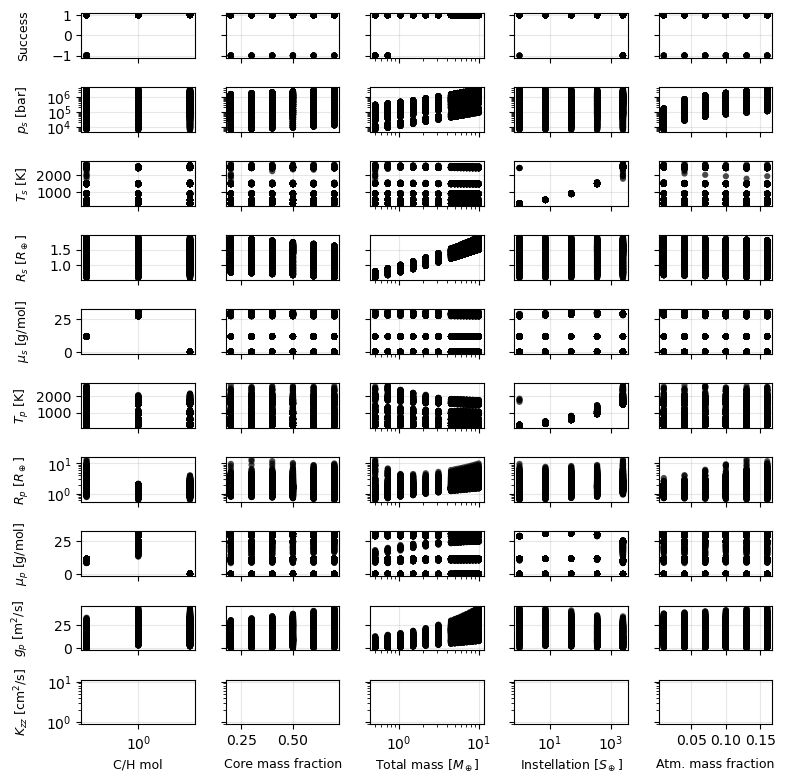

In [184]:

# Create figure with subplots
fig, axes = plt.subplots(len(output_vars), len(input_vars),
                        # figsize=(3*len(input_vars), 2*len(output_vars))
                        figsize=(8,8)
                        )

# If only one row or column, ensure axes is 2D
if len(output_vars) == 1:
    axes = axes.reshape(1, -1)
if len(input_vars) == 1:
    axes = axes.reshape(-1, 1)

# Plot each combination
for i, output_var in enumerate(output_vars):
    for j, input_var in enumerate(input_vars):
        ax = axes[i, j]

        x = np.array(data[input_var]) * units[input_var][0]
        xlabel = units[input_var][2]
        if units[input_var][1]:
            ax.set_xscale("log")

        y = np.array(data[output_var]) * units[output_var][0]
        ylabel = units[output_var][2]
        if units[output_var][1]:
            ax.set_yscale("log")

        # Create scatter plot
        scatter = ax.scatter(x,y, zorder=3, alpha=0.7, s=20,
                                edgecolor='none', linewidth=0.5, color='k')

        # Set labels and title
        if (i == len(output_vars)-1): # or (i == 0):
            ax.set_xlabel(xlabel, fontsize=9)
            if i == 0:
                ax.xaxis.set_label_position('top')
                ax.xaxis.set_tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        else:
            ax.set_xticklabels([])

        if (j == 0):# or (j == len(input_vars)-1) :
            ax.set_ylabel(ylabel, fontsize=9)
            if (j == len(input_vars)-1):
                ax.yaxis.set_label_position('right')
                ax.yaxis.set_tick_params(right=True, labelright=True, left=False, labelleft=False)
        else:
            ax.set_yticklabels([])

        # Add grid
        ax.grid(True, alpha=0.3, zorder=-2)

        # Format axes
        ax.tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout()
fig.align_ylabels()
fig.align_xlabels()

# Save the plot
fig.savefig(os.path.join(plots_dir, "matrix.pdf"), dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [185]:
downsamp = -1

if downsamp > 0:

    fig, axs = plt.subplots(2,1, figsize=(7,7))
    (axt, axb) = axs

    key = "frac_atm"
    zunit = units[key][0]
    norm = mpl.colors.Normalize(vmin=np.amin(data[key])*zunit, vmax=np.amax(data[key])*zunit)
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=batlow)

    al = 0.7
    for i in range(0,gridsize,downsamp):
        col = sm.to_rgba(data.iloc[i][key]*zunit)
        ip = np.argmin(np.abs(data_r[i] - data.iloc[i]["r_phot"]))

        x, y = data_t[i], data_p[i]/bar
        axt.plot(x,y, zorder=2, color=col, alpha=al)
        axt.scatter(x[ip],y[ip], color=col, edgecolors='k', s=20)

        x, y = data_r[i]/R_earth, data_p[i]/bar
        axb.plot(x,y, zorder=2, color=col, alpha=al)
        axb.scatter(x[ip],y[ip], color=col, edgecolors='k', s=20)


    axt.invert_xaxis()
    axt.set_xlabel("Temperature [K]")
    axb.set_xlabel(r"Radius [R$_\oplus$]")
    axb.set_xlim(left=0)

    for ax in axs:
        ax.set_ylabel("Pressure [bar]")
        ax.set_yscale("log")
        ax.invert_yaxis()
        ax.grid(zorder=-2, alpha=0.5)

    fig.colorbar(sm, ax=axt, label=units[key][2], location='top')

    fig.tight_layout()
    fig.align_ylabels()
    fig.savefig(os.path.join(output_dir, "profiles.pdf"), dpi=300, bbox_inches='tight')
    plt.show()

In [186]:
exo_named = [
             ["TRAPPIST-1 b","TRAPPIST-1 c", "TRAPPIST-1 d", "TRAPPIST-1 e"],
             ["L 98-59 b", "L 98-59 c", "L 98-59 d",],
             ["TOI-561 b"],
             ["K2-18 b"],
             ["K2-3 b", "K2-3 c"],
             ["GJ 1214 b"],
             ["55 Cnc Ae"],
             ["TOI-270 d"],
             ["GJ 9827 d"],
             ["LTT 3780 b","LTT 3780 c"],
            #  ["LP 791-18 b", "LP 791-18 c", "LP 791-18 d"],
             ["LHS 1140 b"]
            ]

exo_colors = [mpl.colormaps.get_cmap('rainbow')(x) for x in np.linspace(0,1,len(exo_named))]

## Mass-radius diagrams

In [229]:
mass_ticks = [0.8, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 7, 8.0, 10.0]
radius_ticks = [0.8, 1.0, 1.2, 1.5, 1.8, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0, 7.0]

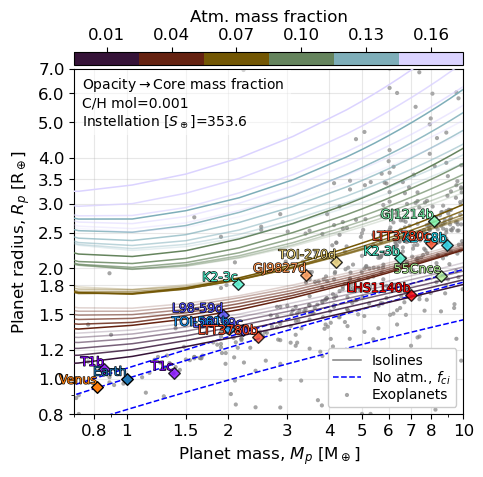

Saved plot to /home2/p321409/Projects/AGNI/out/plots/mass_radius_1.pdf


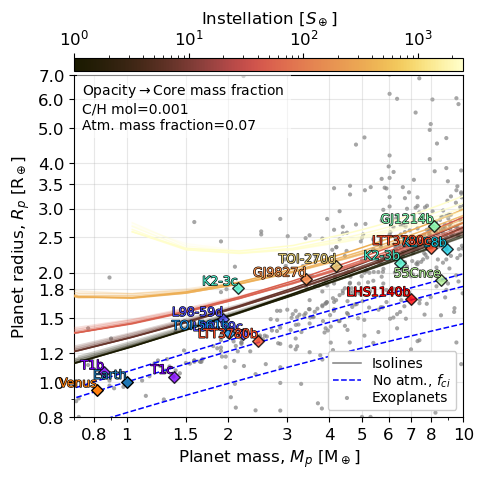

Saved plot to /home2/p321409/Projects/AGNI/out/plots/mass_radius_2.pdf


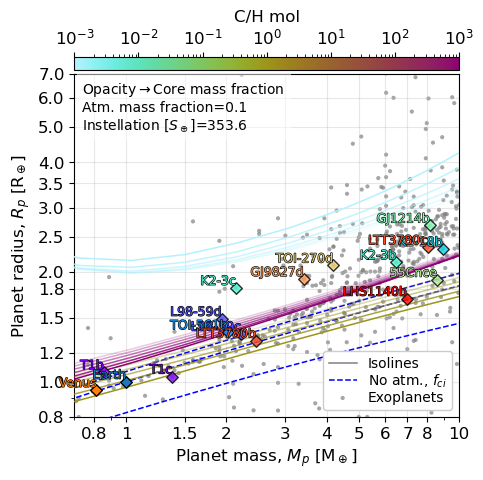

Saved plot to /home2/p321409/Projects/AGNI/out/plots/mass_radius_3.pdf


In [266]:
id = 0

def plot_mr(key1=None, key2=None,controls=None, show_scatter = False, show_isolines = True):
    # copy dataframe
    subdata = deepcopy(data)

    # crop to successful runs (succ==1)
    subdata = subdata[subdata['succ'] > 0.5]

    # create figure object
    fig,ax = plt.subplots(1,1, figsize=(5,5))

    # configure...
    xlim = [0.7, 10.0]
    ylim = [0.8, 7.0]
    s    = 18
    sn   = 35
    lw   = 1.1
    sm2_min = 0.2
    sm2_max = 1.0
    text_pe = [pe.Stroke(linewidth=0.9, foreground='black'), pe.Normal()]
    text_fs = 9
    planet_legend = False


    # choose cmap
    cmap = batlow
    if "metal_" in key1:
        cmap = hawaii_r
    if "frac_atm" in key1:
        cmap = glasgow
    if "instel" in key1:
        cmap = lajolla


    # crop data by control variables
    for c in controls.keys():
        if c == key1:
            raise ValueError("Z-value Key1 cannot also be a control variable")
        if c == key2:
            raise ValueError("Z-value Key2 cannot also be a control variable")
        if c in subdata.columns:
            subdata = subdata[subdata[c] == controls[c]]
    if len(subdata) < 1:
        raise ValueError("No data remaining!")

    # round key2
    # subdata[key2] = np.round(subdata[key2],key2_rnd)

    # colorbar map, for key1
    zunit = units[key1][0]
    vmin, vmax = np.amin(subdata[key1])*zunit, np.amax(subdata[key1])*zunit
    if units[key1][1]: # log scale
        nm1 = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        nm1 = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm1 = mpl.cm.ScalarMappable(norm=nm1, cmap=cmap)

    # opacity map, for key2
    v2_uni = np.unique(subdata[key2].values)
    def sm2(_v):
        _vn = (_v-np.amin(v2_uni))/(np.amax(v2_uni) - np.amin(v2_uni))
        return _vn * (sm2_max - sm2_min) + sm2_min

    # Grid results
    x,y = subdata["mass_tot"], subdata["r_phot"]/R_earth
    if show_scatter:
        c = [sm1.to_rgba(z) for z in subdata[key1]*zunit]
        ax.scatter(x,y, zorder=10, alpha=0.7, edgecolors='k', c=c, label="Model samples", s=s)

    # Plot grid as lines of constant key
    ax.plot([],[],label="Isolines",lw=lw, color='grey')
    isolines = np.unique(subdata[key1])
    if show_isolines:
        # for each key1
        for u in isolines:
            df = subdata[subdata[key1] == u] # get rows with key= this value
            u1 = u*zunit

            # for each key2
            for u2 in np.unique(df[key2]):
                df2 = df[df[key2] == u2]
                xx = np.array(df2["mass_tot"].values)
                yy = np.array(df2["r_phot"].values)/R_earth

                mask_srt = np.argsort(xx) # sort them in ascending mass order
                xx = xx[mask_srt]
                yy = yy[mask_srt]

                alp = sm2(u2)
                col = sm1.to_rgba(u1)
                ax.plot(xx,yy, zorder=300, color=col, alpha=alp, lw=lw)

    # Zeng2019 curves without atmospheres
    col = 'blue'
    ax.plot([],[],ls='dashed', color=col, label=r"No atm., $f_{ci}$", lw=lw)
    for k,(x,y) in zeng.items():
        ax.plot(x,y, zorder=7, ls='dashed', color=col, lw=lw)
        x0 = xlim[1]*1.01
        y0 = y[np.argmin(np.abs(x-x0))]
        # ax.text(x0, y0, k, ha='left', va='center', color=col, fontsize=text_fs)

    # Exoplanets
    ax.scatter(exo_dat["mass"].values * unit_Mjup / unit_Mear,
            exo_dat["radius"].values * unit_Rjup / unit_Rear,
                s=s/2, label="Exoplanets",
                color='gray', edgecolors='none', alpha=0.7, zorder=0, rasterized=True)


    # Named exoplanets
    for j,s in enumerate(exo_named):
        col = exo_colors[j]
        for i,p in enumerate(s):

            try:
                row = exo_dat.loc[exo_dat['name'] == p].iloc[0]
            except IndexError as e:
                print(f"Cannot find planet '{p}' in database")
                continue

            if i == 0:
                lbl = p[:-2]
            else:
                lbl = None
            if not planet_legend:
                lbl = None

            pl = str(p)
            pl = pl.replace("TRAPPIST-1","T1")
            pl = pl.replace("Cnc A","Cnc")
            pl = pl.replace(" ","")

            x = row["mass"] * unit_Mjup / unit_Mear
            y = row["radius"] * unit_Rjup / unit_Rear
            if not (xlim[0] < x < xlim[1]) or not (ylim[0] < y < ylim[1]):
                continue

            a = ax.scatter(x,y, s=sn, label=lbl, alpha=0.8, zorder=901,
                                color=col, ec='k', marker='D')
            if not planet_legend:
                a = ax.text(x,y,pl, color=col, fontsize=text_fs, ha='right', va='bottom', zorder=902, )
                a.set_path_effects(text_pe)

    # Known planets (radius/km, mass/1e24kg)
    # https://ssd.jpl.nasa.gov/planets/phys_par.html
    planets = {
        # "Mercury": [2439.4, 0.33010, 'grey'],
        "Venus":   [6051.8, 4.86731, 'tab:orange'],
        "Earth":   [6371.0, 5.97217, 'tab:blue'],
        # "Mars":    [3389.5, 0.64169, 'tab:red']
    }
    for p,v in planets.items():
        x,y = v[1]*1e24/M_earth, v[0]*1e3/R_earth
        ax.scatter(x,y, label=p if planet_legend else None, zorder=902,
                    s=sn, marker='D', edgecolors='k', color=v[2])
        if not planet_legend:
            a = ax.text(x,y,p, color=v[2], fontsize=text_fs, ha='right', va='bottom', zorder=902, )
            a.set_path_effects(text_pe)

    ax.set_xlabel(r"Planet mass, $M_p$ [M$_\oplus$]")
    ax.set_xlim(xlim)
    # ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.0))
    # ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))

    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%g"))
    ax.xaxis.set_ticks(mass_ticks)

    ax.set_ylabel(r"Planet radius, $R_p$ [R$_\oplus$]")
    ax.set_ylim(ylim)
    # ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1.0))
    # ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))

    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1f"))
    ax.yaxis.set_ticks(radius_ticks)


    # grid
    ax.grid(alpha=0.3, zorder=-2)

    # colorbar
    cbkwargs = {}
    if (not units[key1][1]) and not (len(isolines) > 30):
        cbkwargs = {"values":isolines*zunit,  "ticks":isolines*zunit}

    cb = fig.colorbar(sm1, ax=ax, label=units[key1][2],
                location='top', pad=0.01, aspect=30, **cbkwargs)

    if units[key1][1]:
        cb.ax.set_xscale("log")
        cb.ax.xaxis.set_major_locator(mpl.ticker.LogLocator(numticks=9999))

    # controls annotation
    anno = r"Opacity$\rightarrow$" + f"{units[key2][2]} \n"
    for k,v in controls.items():
        anno += f"{units[k][2]}={v}\n"
    anno = anno[:-1]
    ax.text(0.02, 0.98, anno, transform=ax.transAxes, fontsize=text_fs+1, ha='left',va='top',
            zorder=9999, bbox=dict(facecolor='w', alpha=0.5, edgecolor='none'))

    # legend
    leg = ax.legend(framealpha=1,  loc='lower right', fontsize=text_fs+1,
                        columnspacing=0.8, handletextpad=0.8, labelspacing=0.1)
    leg.set_zorder(99999)

    # show and save
    fig.tight_layout()
    plt.show()

    global id
    id += 1
    outpath = os.path.join(plots_dir, f"mass_radius_{id}.pdf")
    fig.savefig(outpath, dpi=300, bbox_inches='tight')

    print(f"Saved plot to {outpath}")

# ---------------------------

opts = {
    "key1"    : "frac_atm",
    "key2"    : "frac_core",
    "controls": {"metal_C":1e-3, "instellation":3.536000e+02}
}
plot_mr(**opts)

# ---------------------------

opts = {
    "key1"    : "instellation",
    "key2"    : "frac_core",
    "controls": {"metal_C":1e-3, "frac_atm":0.07}
}
plot_mr(**opts)

# ---------------------------

opts = {
    "key1"    : "metal_C",
    "key2"    : "frac_core",
    "controls": {"frac_atm":0.1, "instellation":3.536000e+02}
}
plot_mr(**opts)

## Surface temperatures

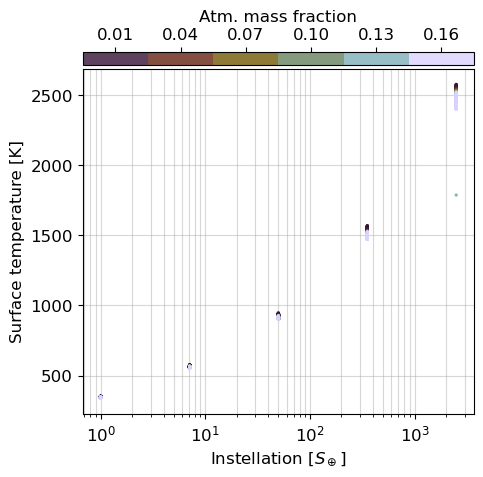

Saved plot to /home2/p321409/Projects/AGNI/out/plots/surface_tmp.pdf


In [261]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

xkey = "instellation"
xlbl = units[xkey][2]

ykey = "t_surf"

zkey = "frac_atm"

# successful runs
df = data[data["succ"] > 0.5]

# plot
z = df[zkey].iloc[:] * units[zkey][0]
x = df[xkey].iloc[:] * units[xkey][0]
y = df[ykey].iloc[:] * units[ykey][0]
sm = ax.scatter(x,y, c=z, s=2, alpha=0.8, zorder=2, cmap=glasgow)

ax.set_xlabel(xlbl)
if units[xkey][1]:
    ax.set_xscale("log")

ax.set_ylabel(r"Surface temperature [K]")

cbtk = np.unique(z)
fig.colorbar(sm, label=units[zkey][2], pad=0.01, location='top', aspect=30,
              values=cbtk, ticks=cbtk)

ax.grid(alpha=0.5, zorder=-2, which='both')

fig.tight_layout()
plt.show()

fname = os.path.join(plots_dir,"surface_tmp.pdf")
fig.savefig(fname, dpi=300, bbox_inches='tight')
print(f"Saved plot to {fname}")

## Gravity defect at photosphere
Due to self-attraction within the atmosphere

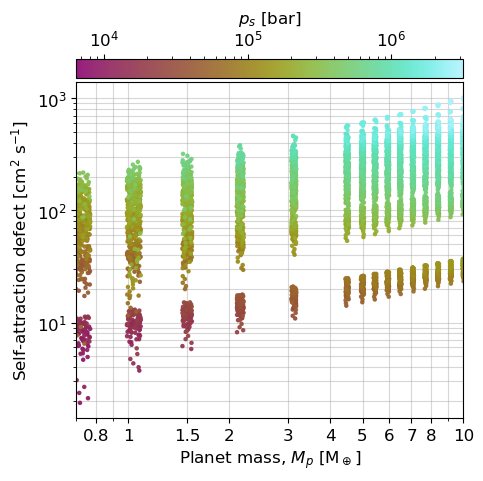

Saved plot to /home2/p321409/Projects/AGNI/out/plots/gravity_defect.pdf


In [286]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

xkey = "mass_tot"
xlbl = "Surface pressure, "+units[xkey][2]

zkey = "p_surf"

# successful runs
df = data[data["succ"] > 0.5]

# surface gravity
gs = Gconst * df["mass_tot"] * M_earth * (1-df["frac_atm"]) / np.array(df["r_surf"])**2

# expected photosphere gravity
gp = gs * (df["r_surf"]/df["r_phot"])**2

c = df[zkey].iloc[:] * units[zkey][0]
x = df[xkey].iloc[:] * units[xkey][0]
x += (np.random.rand(len(x))-0.5)*0.1
y = 100*(df["g_phot"].iloc[:] * units["g_phot"][0] - gp)
sm = ax.scatter(x,y, c=c, s=5, alpha=0.9, zorder=2, cmap=hawaii, rasterized=True, norm='log')

ax.set_xlabel(r"Planet mass, $M_p$ [M$_\oplus$]")
ax.set_xscale("log")
ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%g"))
ax.xaxis.set_ticks(mass_ticks)
ax.set_xlim(0.7, 10)

ax.set_ylabel(r"Self-attraction defect [cm$^2$ s$^{-1}$]")
ax.set_yscale("log")

cbtk = np.unique(z)
cb = fig.colorbar(sm, label=units[zkey][2], pad=0.01, location='top')

ax.grid(alpha=0.5, zorder=-2, which='both')

fig.tight_layout()
plt.show()

fname = os.path.join(plots_dir,"gravity_defect.pdf")
fig.savefig(fname, dpi=300, bbox_inches='tight')
print(f"Saved plot to {fname}")